## Problem 2: Optimal Scheduling of Load Time Intervals within Groups

In this problem we imagine a charging park shared by n companies. Different companies have different time slots during which they'd like to use the park, but no two companies can use the park at the same time. We now have to assign different companies different time slots during which they can use the charging park, the goal being to include as many companies as we can. This should happen under the condition that no company is overrepresented, so each company only gets one time slot if any.

To solve this problem we create a graph where each node represents a 'job' or a possible time interval during which the company would like to use the charging park. Two nodes are connected if the time intervals they represent overlap, or if they belong to the same group (the same company). In terms of this graph, the problem then is to find the largest set of nodes in this graph that share no edges, or in other words we're trying to find the "maximum independent set" (MIS).

This problem can also be solved using QAOA.

## Encoding qubits

We use $n$ qubits, each to represent a node on the graph. By the end of the algorithm, the qubits that are measured as 1 will be part of our maximum independent subset.

## Cost Hamiltonian

Unlike problem 1, the Cost Hamiltonian is much more simple to implement than the Mixer Hamiltonian.
If $V$ is the set of vertices in our graph,

$H_C=\frac{1}{2}\sum\limits_{u\in V}(1-Z_u)$

The operator $e^{-iH_C\gamma}$ can be implemented by applying an Rz(-γ) gate on each qubit.
The cost here is just -1 times the total number of nodes in our independent set. Note that we haven't done anything to ensure that this is an independent set in the cost hamiltonian. This is a constraint that we have to enforce through the mixer hamiltonian.

## Mixer Hamiltonian

A valid Mixer Hamiltonian for this problem is

$H_M=\sum\limits_{u\in V} X_u\prod\limits_{j=1}^l\frac{1+Z_{v_j}}{2}$

Here $\{v_j\}$ is the set of neighbors of $u$. The part inside the product operator by itself can be exponentiated in the same way we did the cost hamiltonian for the max-k-cut problem. Trouble is we need to deal with the $X$ gate. However, if we want to exponentiate a single term (pertaining to some node $u’$) of this sum, what we can do is we can change the basis of the $u’$ qubit by itself to make that $X$ a $Z$. Say $u’$ has two adjacent nodes for example. The matrix exponent of that single term in $H_M$ corresponding to $u'$ is

$e^{X\otimes ((I+Z)/2)\otimes ((I+Z)/2)}
= e^{(HZH)\otimes ((I+Z)/2)\otimes ((I+Z)/2)}
= (H\otimes I\otimes I) e^{Z\otimes ((I+Z)/2)\otimes ((I+Z)/2)} (H\otimes I\otimes I)$

In terms of gates, this means we first apply a hadamard gate on the $u’$ qubit. Then for every combination of the neighboring nodes of $u'$, we do the following:

- Let's call the combination of neighboring nodes that we picked $V'$.
- We first apply a chain of $CNOT$ gates across the qubits in $V'$.
- We finish the chain by applying a CNOT that ends on the $u'$ qubit
- Then we apply $R_Z(\frac{\gamma}{2^{k-1}})$ on the $u'$ qubit, where $k$ is the size of $V'$.
- Lastly we undo all the $CNOT$s.

We do this for every combination of neighbors of $u'$ and finish it off by applying a final $H$ gate to $u'$.

In [1]:
from Code.data_processing import *
from Code.Max_k_cut_quantum_functions import *
from Code.Max_k_cut_classical_functions import *
from Code.Maximal_independent_set_quantum_functions import *

In [2]:
# Set parameters here

p = 2  # the depth of QAOA

ng = 4  # number_of_groups 
    
n = 10  # total number of nodes, or vehicles

mt = 500  # max_time, Start time charging limit (say, after 100 minutes, every car started at least charging)

mct = 100  # max_charging_time, maximum time a car can charge (like 6h)

U = 10  # The size of punishment added to the cost due to including nodes of the same group in the MIS

nshots = 512  # the number of shots per iteration

init_params = [np.pi/8, np.pi]*p  # the initial parameters gammas and betas. This is however unused in the full
                                  # optimization loop since the educated global guess optimization does not require
                                  # initial guesses. The init_params here will be used later to demonstrate the 
                                  # performance of a local optimzation alone.

local_optimization_method = 'Powell'  # the local optimization algorithm to be used, supported by Scipy. 
                                      # good candidates include 'Powell', 'COBYLA', 'Nelder-Mead', 'BFGS'

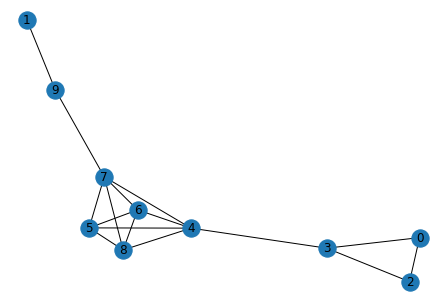

In [3]:
G = generate_data_mis(ng, n, mt, mct)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

In [4]:
adj = get_adjacency_matrix(G)

In [5]:
mb = make_cost_block_MIS(n,1)  # building the mixing block
mb.draw()

┌─────────┐
q_0: ┤ RZ(-γ1) ├
     ├─────────┤
q_1: ┤ RZ(-γ1) ├
     ├─────────┤
q_2: ┤ RZ(-γ1) ├
     ├─────────┤
q_3: ┤ RZ(-γ1) ├
     ├─────────┤
q_4: ┤ RZ(-γ1) ├
     ├─────────┤
q_5: ┤ RZ(-γ1) ├
     ├─────────┤
q_6: ┤ RZ(-γ1) ├
     ├─────────┤
q_7: ┤ RZ(-γ1) ├
     ├─────────┤
q_8: ┤ RZ(-γ1) ├
     ├─────────┤
q_9: ┤ RZ(-γ1) ├
     └─────────┘

In [6]:
cb = make_mixing_block_MIS(n, adj, 1)  # building the cost block 
cb.draw()

┌───┐┌────────────┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌────────┐┌───┐ ░      »
q_0: ┤ H ├┤ RZ(2.0*β1) ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░──────»
     └───┘└────────────┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘└────────┘└─┬─┘ ░      »
q_1: ────────────────────░───┼──────────────┼───░───┼──────────────┼───░──────»
                         ░   │              │   ░   │              │   ░      »
q_2: ────────────────────░───■──────────────■───░───┼──────────────┼───░───■──»
                         ░                      ░   │              │   ░ ┌─┴─┐»
q_3: ────────────────────░──────────────────────░───■──────────────■───░─┤ X ├»
                         ░                      ░                      ░ └───┘»
q_4: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_5: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_6: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_7: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_8: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_9: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
«     ┌───┐┌──────────┐┌───┐      ░ ┌───┐               ░                     »
«q_0: ┤ X ├┤ RZ(β1/2) ├┤ X ├──────░─┤ H ├───────────────░─────────────────────»
«     └─┬─┘└──────────┘└─┬─┘      ░ ├───┤┌────────────┐ ░ ┌───┐┌────────┐┌───┐»
«q_1: ──┼────────────────┼────────░─┤ H ├┤ RZ(2.0*β1) ├─░─┤ X ├┤ RZ(β1) ├┤ X ├»
«       │                │        ░ └───┘└────────────┘ ░ └─┬─┘└────────┘└─┬─┘»
«q_2: ──┼────────────────┼────■───░─────────────────────░───┼──────────────┼──»
«       │                │  ┌─┴─┐ ░                     ░   │              │  »
«q_3: ──■────────────────■──┤ X ├─░─────────────────────░───┼──────────────┼──»
«                           └───┘ ░                     ░   │              │  »
«q_4: ────────────────────────────░─────────────────────░───┼──────────────┼──»
«                                 ░                     ░   │              │  »
«q_5: ────────────────────────────░─────────────────────░───┼──────────────┼──»
«                                 ░                     ░   │              │  »
«q_6: ────────────────────────────░─────────────────────░───┼──────────────┼──»
«                                 ░                     ░   │              │  »
«q_7: ────────────────────────────░─────────────────────░───┼──────────────┼──»
«                                 ░                     ░   │              │  »
«q_8: ────────────────────────────░─────────────────────░───┼──────────────┼──»
«                                 ░                     ░   │              │  »
«q_9: ────────────────────────────░─────────────────────░───■──────────────■──»
«                                 ░                     ░                     »
«      ░                     ░                      ░                      ░ »
«q_0: ─░─────────────────────░───■──────────────■───░──────────────────────░─»
«      ░ ┌───┐               ░   │              │   ░                      ░ »
«q_1: ─░─┤ H ├───────────────░───┼──────────────┼───░──────────────────────░─»
«      ░ ├───┤┌────────────┐ ░ ┌─┴─┐┌────────┐┌─┴─┐ ░ ┌───┐┌────────┐┌───┐ ░ »
«q_2: ─░─┤ H ├┤ RZ(2.0*β1) ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░─»
«      ░ └───┘└────────────┘ ░ └───┘└────────┘└───┘ ░ └─┬─┘└────────┘└─┬─┘ ░ »
«q_3: ─░─────────────────────░──────────────────────░───■──────────────■───░─»
«      ░     

In [7]:
circ = make_full_circuit_MIS(n,adj,p)  # building the full circuit
circ.decompose().draw()

┌─────────┐┌───┐┌────────────┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐»
    q_0: ┤ RZ(-γ0) ├┤ H ├┤ RZ(2.0*β0) ├─░─┤ X ├┤ RZ(β0) ├┤ X ├─░─┤ X ├»
         ├─────────┤└───┘└────────────┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘»
    q_1: ┤ RZ(-γ0) ├────────────────────░───┼──────────────┼───░───┼──»
         ├─────────┤                    ░   │              │   ░   │  »
    q_2: ┤ RZ(-γ0) ├────────────────────░───■──────────────■───░───┼──»
         ├─────────┤                    ░                      ░   │  »
    q_3: ┤ RZ(-γ0) ├────────────────────░──────────────────────░───■──»
         ├─────────┤                    ░                      ░      »
    q_4: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_5: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_6: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_7: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_8: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_9: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         └─────────┘                    ░                      ░      »
meas: 10/═════════════════════════════════════════════════════════════»
                                                                      »
«         ┌────────┐┌───┐ ░      ┌───┐┌──────────┐┌───┐      ░ ┌───┐»
«    q_0: ┤ RZ(β0) ├┤ X ├─░──────┤ X ├┤ RZ(β0/2) ├┤ X ├──────░─┤ H ├»
«         └────────┘└─┬─┘ ░      └─┬─┘└──────────┘└─┬─┘      ░ ├───┤»
«    q_1: ────────────┼───░────────┼────────────────┼────────░─┤ H ├»
«                     │   ░        │                │        ░ └───┘»
«    q_2: ────────────┼───░───■────┼────────────────┼────■───░──────»
«                     │   ░ ┌─┴─┐  │                │  ┌─┴─┐ ░      »
«    q_3: ────────────■───░─┤ X ├──■────────────────■──┤ X ├─░──────»
«                         ░ └───┘                      └───┘ ░      »
«    q_4: ────────────────░──────────────────────────────────░──────»
«                         ░                                  ░      »
«    q_5: ────────────────░──────────────────────────────────░──────»
«                         ░                                  ░      »
«    q_6: ────────────────░──────────────────────────────────░──────»
«                         ░                                  ░      »
«    q_7: ────────────────░──────────────────────────────────░──────»
«                         ░                                  ░      »
«    q_8: ────────────────░──────────────────────────────────░──────»
«                         ░                                  ░      »
«    q_9: ────────────────░──────────────────────────────────░──────»
«                         ░                                  ░      »
«meas: 10/══════════════════════════════════════════════════════════»
«                                                                   »
«                        ░                      ░                     ░      »
«    q_0: ───────────────░──────────────────────░─────────────────────░───■──»
«         ┌────────────┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐               ░   │  »
«    q_1: ┤ RZ(2.0*β0) ├─░─┤ X ├┤ RZ(β0) ├┤ X ├─░─┤ H ├───────────────░───┼──»
«         └────────────┘ ░ └─┬─┘└────────┘└─┬─┘ ░ ├───┤┌────────────┐ ░ ┌─┴─┐»
«    q_2: ───────────────░───┼──────────────┼───░─┤ H ├┤ RZ(2.0*β0) ├─░─┤ X ├»
«                        ░   │              │   ░ └───┘└────────────┘ ░ └───┘»
«    q_3: ───────────────░───┼──────────────┼───░─────────────────────░──────»
«                        ░   │              │   ░                     ░      »
«    q_4: ───────────────░───┼──

In [8]:
counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)  # visualize the circuit to be runned
transpiled_circ.decompose().draw()

global phase: -13π/8
         ┌──────────────────┐ ░ ┌───┐┌─────────┐┌───┐ ░ ┌───┐┌─────────┐┌───┐»
    q_0: ┤ U3(π/2,π/4,7π/8) ├─░─┤ X ├┤ U1(π/8) ├┤ X ├─░─┤ X ├┤ U1(π/8) ├┤ X ├»
         └───┬──────────┬───┘ ░ └─┬─┘└─────────┘└─┬─┘ ░ └─┬─┘└─────────┘└─┬─┘»
    q_1: ────┤ U1(-π/8) ├─────░───┼───────────────┼───░───┼───────────────┼──»
             ├──────────┤     ░   │               │   ░   │               │  »
    q_2: ────┤ U1(-π/8) ├─────░───■───────────────■───░───┼───────────────┼──»
             ├──────────┤     ░                       ░   │               │  »
    q_3: ────┤ U1(-π/8) ├─────░───────────────────────░───■───────────────■──»
             ├──────────┤     ░                       ░                      »
    q_4: ────┤ U1(-π/8) ├─────░───────────────────────░──────────────────────»
             ├──────────┤     ░                       ░                      »
    q_5: ────┤ U1(-π/8) ├─────░───────────────────────░──────────────────────»
             ├──────────┤     ░                       ░                      »
    q_6: ────┤ U1(-π/8) ├─────░───────────────────────░──────────────────────»
             ├──────────┤     ░                       ░                      »
    q_7: ────┤ U1(-π/8) ├─────░───────────────────────░──────────────────────»
             ├──────────┤     ░                       ░                      »
    q_8: ────┤ U1(-π/8) ├─────░───────────────────────░──────────────────────»
             ├──────────┤     ░                       ░                      »
    q_9: ────┤ U1(-π/8) ├─────░───────────────────────░──────────────────────»
             └──────────┘     ░                       ░                      »
meas: 10/════════════════════════════════════════════════════════════════════»
                                                                             »
«          ░      ┌───┐┌──────────┐┌───┐      ░    ┌─────────┐    ░      »
«    q_0: ─░──────┤ X ├┤ U1(π/16) ├┤ X ├──────░────┤ U2(0,π) ├────░──────»
«          ░      └─┬─┘└──────────┘└─┬─┘      ░ ┌──┴─────────┴──┐ ░ ┌───┐»
«    q_1: ─░────────┼────────────────┼────────░─┤ U3(π/2,π/4,π) ├─░─┤ X ├»
«          ░        │                │        ░ └───────────────┘ ░ └─┬─┘»
«    q_2: ─░───■────┼────────────────┼────■───░───────────────────░───┼──»
«          ░ ┌─┴─┐  │                │  ┌─┴─┐ ░                   ░   │  »
«    q_3: ─░─┤ X ├──■────────────────■──┤ X ├─░───────────────────░───┼──»
«          ░ └───┘                      └───┘ ░                   ░   │  »
«    q_4: ─░──────────────────────────────────░───────────────────░───┼──»
«          ░                                  ░                   ░   │  »
«    q_5: ─░──────────────────────────────────░───────────────────░───┼──»
«          ░                                  ░                   ░   │  »
«    q_6: ─░──────────────────────────────────░───────────────────░───┼──»
«          ░                                  ░                   ░   │  »
«    q_7: ─░──────────────────────────────────░───────────────────░───┼──»
«          ░                                  ░                   ░   │  »
«    q_8: ─░──────────────────────────────────░───────────────────░───┼──»
«          ░                                  ░                   ░   │  »
«    q_9: ─░──────────────────────────────────░───────────────────░───■──»
«          ░                                  ░                   ░      »
«meas: 10/═══════════════════════════════════════════════════════════════»
«                                                                        »
«                          ░                   ░                       ░      »
«    q_0: ─────────────────░───────────────────░───■───────────────■───░──────»
«         ┌─────────┐┌───┐ ░    ┌─────────┐    ░   │               │   ░      »
«    q_1: ┤ U1(π/8) ├┤ X ├─░────┤ U2(0,π) ├────░───┼───────────────┼───░──────»
«         └─────────┘└─┬─┘ ░ ┌──┴─────────┴──┐ ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░ ┌───┐»
«    q_2: ─────────────┼───░─┤ U3(π/2

In [13]:
average_cost = compute_cost_MIS(counts,adj, U)
average_cost

26.5390625

In [11]:
func_to_optimize = func_to_optimize_wrapper_MIS(circ, adj, U, nshots=512, simulator='aer_simulator')

In [12]:
res = minimize(func_to_optimize, init_params, method=local_optimization_method)
print('cost', res.fun)
print('parameters', res.x)

cost 21.18359375
parameters [ 0.77465785  2.82478591 -1.13516493  3.90552469]
